<h1 align="center">ADVANCING AGE-INVARIANT FACIAL RECOGNITION IN AFRICAN INDIGENOUS POPULATIONS</h1>

<h1 align="center">PART I: TRAINING ON FAGE DATASET</h1>

## 1. Import Libraries

In [1]:
import random
import os
import glob

from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import keras
from keras import ops
from keras.applications import ResNet50

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model ,load_model

2024-04-10 20:20:43.230959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 20:20:43.231078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 20:20:43.343738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Prepare Datasets

In [2]:
def data_preparation(folder_path):
    # Initialize an empty dictionary to store the mapping
    mapping = {}

    # Traverse the folder structure
    for root, dirs, files in os.walk(folder_path):
        # Extract the person name from the current path
        person_name = os.path.basename(root)
        
        if "Quick access - Shortcut.lnk" in files:
            continue

        # Check if the current directory contains images
        if files:
            # Construct the full path for each image
            image_paths = [os.path.join(root, file) for file in files]

            # Update the mapping with the person name and corresponding image paths
            mapping[person_name] = image_paths
            
    return mapping

### 2.1. FAGE Dataset

In [3]:
old_fage_training_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/FAGE/FAGE Training/FAGE (old)/Training"
extended_fage_training_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/FAGE/FAGE Training/FAGE_extended_v2"

old_fage_training = data_preparation(old_fage_training_folder_path)
extended_fage_training = data_preparation(extended_fage_training_folder_path)

In [4]:
fage_training = {}

for k, v in old_fage_training.items():
    fage_training[k] = v
    
for k, v in extended_fage_training.items():
    fage_training[k] = v

In [5]:
fage_validation_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/FAGE/FAGE Val Set"
fage_test_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/FAGE/FAGE Training/FAGE (old)/Test"

fage_validation = data_preparation(fage_validation_folder_path)
fage_test = data_preparation(fage_test_folder_path)

### 2.2. CACD Dataset

In [6]:
cacd_training_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/CACD/Training"
cacd_validation_folder_path = "/kaggle/input/fage-and-cacd/FAGE and CACD/CACD/Val"

cacd_training = data_preparation(cacd_training_folder_path)
cacd_validation = data_preparation(cacd_validation_folder_path)

### 2.3. Image Pair Generation

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32)/255.0
    return input_image

In [9]:
def load_images_and_labels(mapping, target_size=(80, 80)):
    images = []
    labels = []

    for index, (key, image_paths) in enumerate(mapping.items()):
        labels.extend([index] * len(image_paths))
        for path in image_paths:
            img = load_img(path, target_size=target_size)  # resize image
            img = normalize(img)
            image = img_to_array(img)
            images.append(image)
            
#         if index == 10:
#             break

    return np.array(images), np.array(labels)

In [10]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [11]:
def get_pairs(dataset):
    images, labels = load_images_and_labels(dataset)
    
    images, labels = generate_image_pairs(images, labels)
    
    images, labels = shuffle(images, labels)
    
    return images, labels

In [12]:
fage_training_images, fage_training_labels = get_pairs(fage_training)
fage_validation_images, fage_validation_labels = get_pairs(fage_validation)
fage_test_images, fage_test_labels = get_pairs(fage_test)

del fage_training, fage_validation, fage_test

In [13]:
cacd_training_images, cacd_training_labels = get_pairs(cacd_training)
cacd_validation_images, cacd_validation_labels = get_pairs(cacd_validation)

del cacd_training, cacd_validation

In [14]:
print(np.unique(fage_training_labels))
print(np.unique(fage_validation_labels))
print(np.unique(fage_test_labels))

[0 1]
[0 1]
[0 1]


## 3. Image Visualization: Visualize Image Pairs

In [15]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

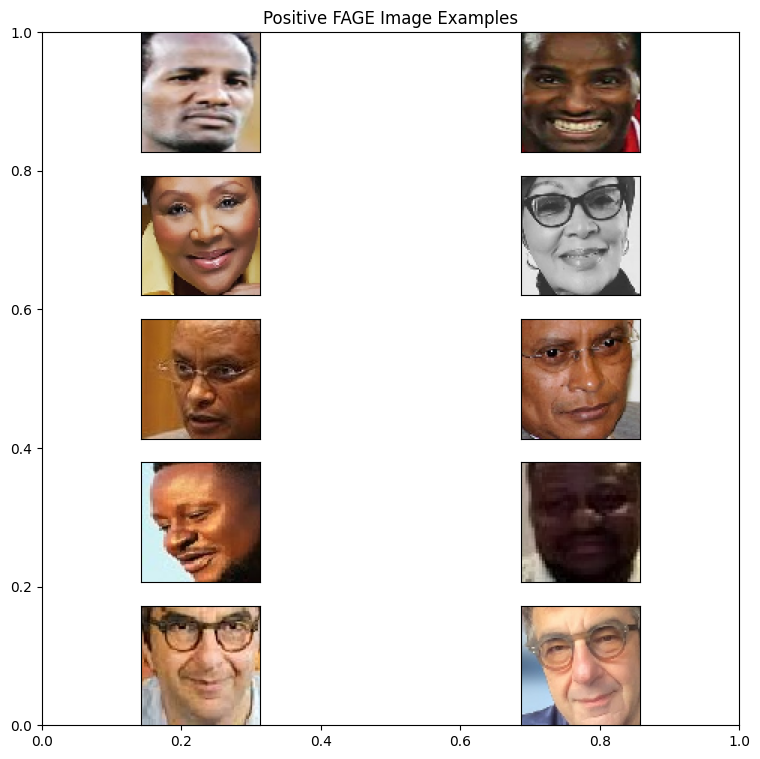

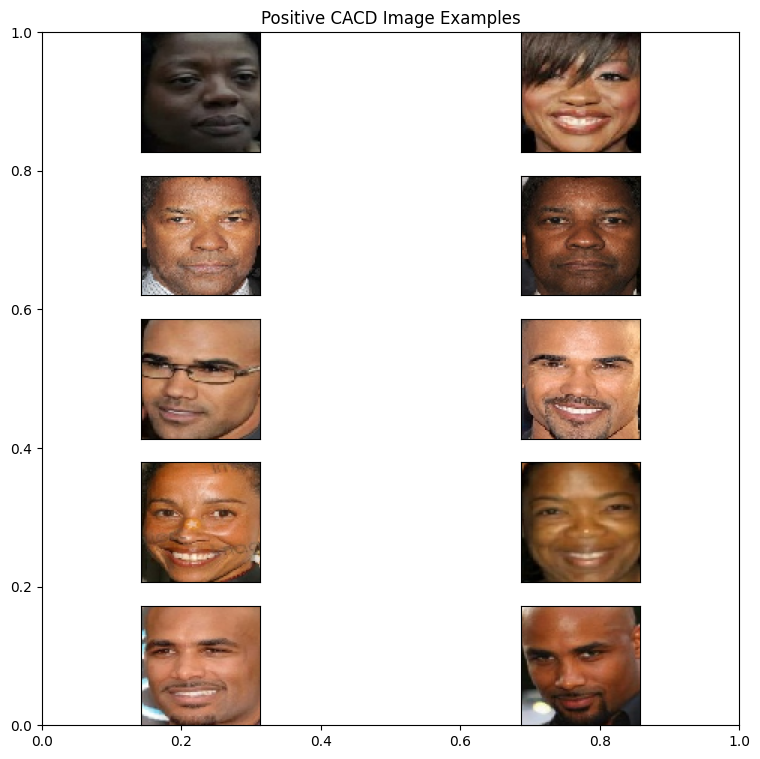

In [16]:
# Visualize Positive Images
n = 5
indices = np.where(fage_training_labels == 1)[:n]
visualize(fage_training_images[indices], fage_training_labels[indices],
          title = "Positive FAGE Image Examples", n=n)

# Visualize Positive Images
n = 5
indices = np.where(cacd_training_labels == 1)[:n]
visualize(cacd_training_images[indices], cacd_training_labels[indices],
          title = "Positive CACD Image Examples", n=n)

del indices

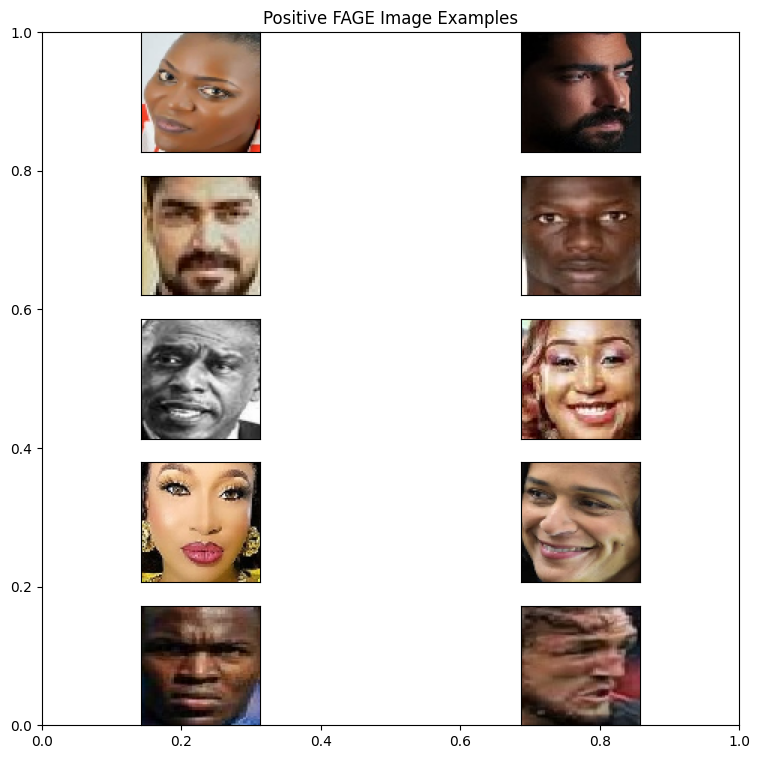

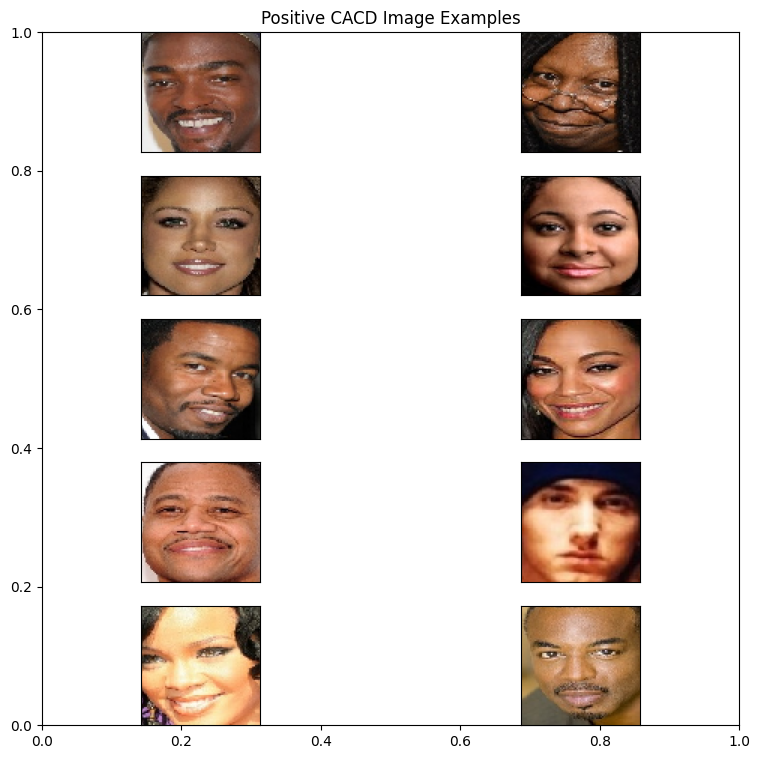

In [17]:
# Visualize Negative Images
n = 5
indices = np.where(fage_training_labels == 0)[:n]
visualize(fage_training_images[indices], fage_training_labels[indices],
          title = "Positive FAGE Image Examples", n=n)

# Visualize Negative Images
n = 5
indices = np.where(cacd_training_labels == 0)[:n]
visualize(cacd_training_images[indices], cacd_training_labels[indices],
          title = "Positive CACD Image Examples", n=n)

del indices

In [18]:
print(f"The shape of the training data is {fage_training_images.shape}")
print(f"The shape of the validation data is {fage_validation_images.shape}")
print(f"The shape of the testing data is {fage_test_images.shape}")

The shape of the training data is (25202, 2, 80, 80, 3)
The shape of the validation data is (3102, 2, 80, 80, 3)
The shape of the testing data is (2000, 2, 80, 80, 3)


## 4. Split Image Pairs

### 4.1. FAGE Pair

In [19]:
x_train_fage_1 = fage_training_images[:, 0, :]
x_train_fage_2 = fage_training_images[:, 1, :]

x_val_fage_1 = fage_validation_images[:, 0, :]
x_val_fage_2 = fage_validation_images[:, 1, :]

x_test_fage_1 = fage_test_images[:, 0, :]
x_test_fage_2 = fage_test_images[:, 1, :]

# del x_train_fage, x_val_fage, x_test_fage 

### 4.2. CACD Pair

In [20]:
cacd_images_1 = cacd_training_images[:, 0, :]
cacd_images_2 = cacd_training_images[:, 1, :]

cacd_labels = cacd_training_labels.copy()

## 5. Model Architecture (Siamese Network)

### 5.1. Hyperparameters

In [21]:
epochs = 50
batch_size = 16
margin = 1  # Margin for contrastive loss
data_shape = (80, 80, 3)

### 5.2. Embedding Layer 

In [22]:
input = keras.layers.Input((80, 80, 3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)

In [23]:
# input = keras.layers.Input((100, 100, 3))

# x = keras.layers.BatchNormalization()(input)
# x = keras.layers.Conv2D(32, (5, 5), activation="tanh", padding='same')(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = keras.layers.Conv2D(64, (5, 5), activation="tanh", padding='same')(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = keras.layers.Conv2D(128, (5, 5), activation="tanh", padding='same')(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(128, activation="relu")(x)
# x = keras.layers.Dropout(0.5)(x)

# embedding_network = keras.Model(input, x)

In [24]:
# from tensorflow.keras.applications import ResNet50

# # Load ResNet50 model, pretrained on imagenet
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# # Make sure ResNet is not trainable
# for layer in resnet.layers:
#     layer.trainable = False

# x = resnet.get_layer('conv5_block3_out').output
# model_out = keras.layers.Flatten()(x)
# model_out =  keras.layers.Dense(10, activation="relu")(model_out)
# embedding_network = tf.keras.models.Model(inputs=resnet.input, outputs=model_out)

### 5.3. Distance Layer

In [25]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

### 5.4. Contraceptive Loss

In [26]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

### 5.5 Rank-1 Recognition Accuracy

In [27]:
def rank_1_accuracy(y_true, y_pred):
    y_pred_indices = tf.argmax(y_pred, axis=1)

    correct_predictions = tf.equal(y_pred_indices, tf.cast(y_true, dtype=tf.int64))

    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

    return accuracy

### 6.6. Siamese Network

In [28]:
input_1 = keras.layers.Input((80, 80, 3))
input_2 = keras.layers.Input((80, 80, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="tanh")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [29]:
# siamese.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
siamese.compile(loss='binary_crossentropy', optimizer="adam", metrics=[rank_1_accuracy])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10)        │     66,678 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,684 (260.48 KB)

 Trainable params: 57,428 (224.33 KB)

 Non-trainable params: 9,256 (36.16 KB)

In [30]:
x_train_fage_1.shape

(25202, 80, 80, 3)

In [31]:
history = siamese.fit(
    [x_train_fage_1, x_train_fage_2],
    fage_training_labels,
    validation_data=([x_val_fage_1, x_val_fage_2], fage_validation_labels),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/50
  26/1576 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 3.7091 - rank_1_accuracy: 0.5169 

I0000 00:00:1712780649.325192     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712780649.344704     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1576/1576 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0346 - rank_1_accuracy: 0.5008

W0000 00:00:1712780658.384347     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712780660.181174     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1576/1576 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 3.0342 - rank_1_accuracy: 0.5008 - val_loss: 1.4991 - val_rank_1_accuracy: 0.4999
Epoch 2/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.7633 - rank_1_accuracy: 0.4974 - val_loss: 1.3372 - val_rank_1_accuracy: 0.4999
Epoch 3/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.3058 - rank_1_accuracy: 0.5020 - val_loss: 0.7948 - val_rank_1_accuracy: 0.4999
Epoch 4/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7576 - rank_1_accuracy: 0.5013 - val_loss: 0.6981 - val_rank_1_accuracy: 0.4999
Epoch 5/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6862 - rank_1_accuracy: 0.4967 - val_loss: 0.6882 - val_rank_1_accuracy: 0.4999
Epoch 6/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6747 - rank_1_accuracy: 0.5005 - val_loss: 0.6794 - val_rank_1_accuracy: 0.4999
Epoch 7/50
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6562 - rank_1_accuracy: 0.4976 - val_loss: 0.6948 - val_rank_1_accuracy: 0.4999
Ep

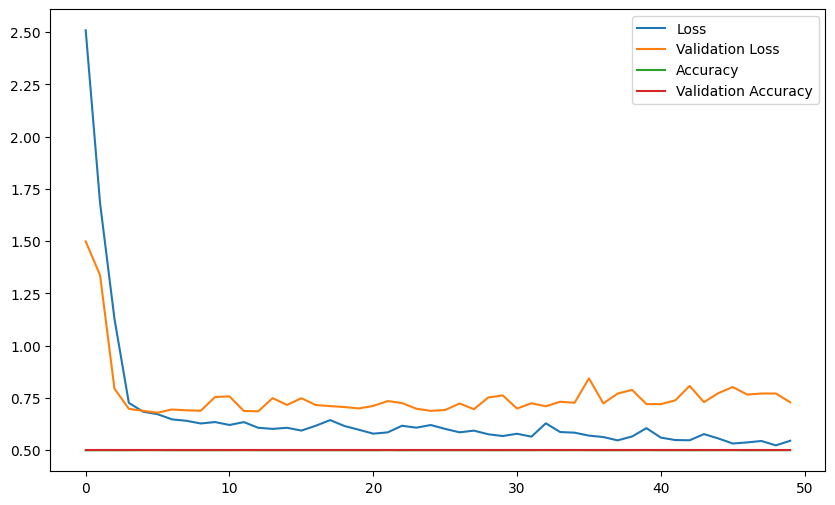

In [32]:
# Training Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["rank_1_accuracy"])
plt.plot(history.history["val_rank_1_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"]);

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


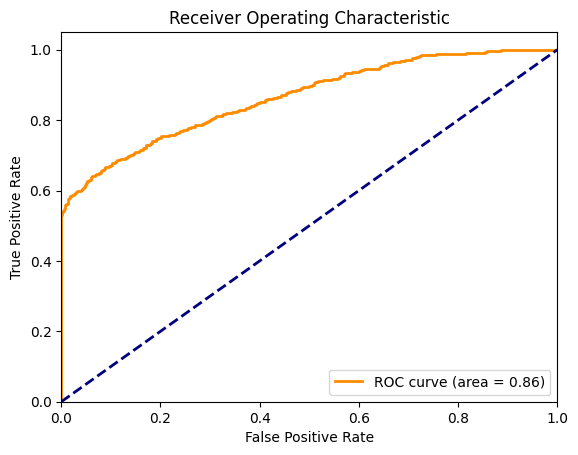

In [33]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = siamese.predict([x_test_fage_1, x_test_fage_2])

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(fage_test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 7. Model Evaluation

### 7.1. Evaluation on FAGE

In [34]:
results = siamese.evaluate([x_test_fage_1, x_test_fage_2], fage_test_labels)
print("test loss, test acc:", results)

36/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5357 - rank_1_accuracy: 0.5121 

W0000 00:00:1712780993.869439     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5270 - rank_1_accuracy: 0.5071
test loss, test acc: [0.508258044719696, 0.4990079402923584]


### 7.2. Evaluation on CACD

In [35]:
results = siamese.evaluate([cacd_images_1, cacd_images_2], cacd_labels)
print("test loss, test acc:", results)

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6971 - rank_1_accuracy: 0.5004
test loss, test acc: [0.6863999366760254, 0.5003623366355896]


## 8. Result Visualization

In [36]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

In [37]:
def visualize_predictions(siamese, x_test_1, x_test_2, y_test_fage, n=5):
    # Get the indices where y_test_fage is 1
    indices = np.where(y_test_fage == 1)[0]

    # Select a random index from these
    idx = np.random.choice(indices)

    # This will be the test_image
    test_image = x_test_1[idx]
    
    fig = plt.figure(figsize=(3, 3)) 
    axs = fig.subplots(1, 1)

    plt.imshow(test_image);

    # Its counterpart in the second array
    counterpart_image = x_test_2[idx]

    # Select 4 random images
    random_indices = np.random.choice(len(x_test_1), n-1, replace=False)
    random_images = x_test_1[random_indices]

    # Combine the images
    images = np.concatenate(([counterpart_image], random_images))

    # Create pairs with the test_image
    image_pairs = np.stack([test_image]*n, axis=0), images

    # Predict
    scores = siamese.predict(image_pairs)

    # Visualize
    test_visualize(images)

    return scores


### 8.1. Visualizing FAGE Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[ 0.8046678 ],
       [-0.28246692],
       [ 0.7148433 ],
       [-0.5492079 ],
       [-0.29468775]], dtype=float32)

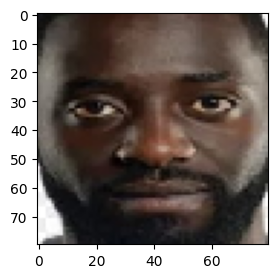

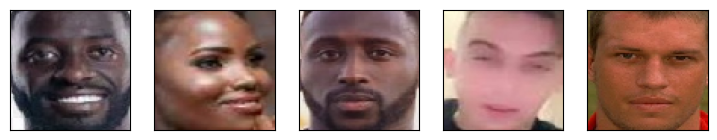

In [53]:
visualize_predictions(siamese, x_test_fage_1, x_test_fage_2, fage_test_labels, n=5)

### 8.2. Visualizing CACD Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[0.9341705 ],
       [0.665061  ],
       [0.26702657],
       [0.5540701 ],
       [0.4713848 ]], dtype=float32)

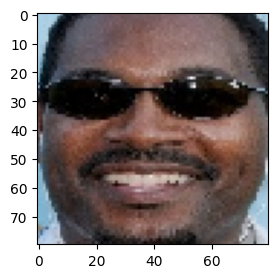

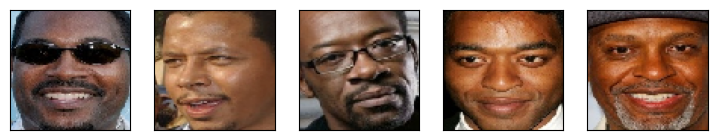

In [39]:
visualize_predictions(siamese, cacd_images_1, cacd_images_1, cacd_labels, n=5)

<h1 align="center">PART II: TRAINING ON CACD DATASET</h1>

In [40]:
# Select test set out of cacd training set
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2

# Calculate the sizes
train_size = int(len(cacd_training_images) * TRAIN_SIZE)
test_size = int(len(cacd_training_images) * TEST_SIZE)

# Split the data
x_train_cacd = cacd_training_images[:train_size]
y_train_cacd = cacd_training_labels[:train_size]

x_test_cacd = cacd_training_images[train_size:train_size + test_size]
y_test_cacd = cacd_training_labels[train_size:train_size + test_size]

In [41]:
x_val_cacd = cacd_validation_images.copy()
y_val_cacd = cacd_validation_labels.copy()

In [42]:
print(f"The shape of the training data is {x_train_cacd.shape}")
print(f"The shape of the validation data is {x_val_cacd.shape}")
print(f"The shape of the testing data is {x_test_cacd.shape}")

The shape of the training data is (7716, 2, 80, 80, 3)
The shape of the validation data is (2564, 2, 80, 80, 3)
The shape of the testing data is (2204, 2, 80, 80, 3)


## 1. Split Image Pairs

### 1.1. CACD Pair

In [43]:
x_train_cacd_1 = x_train_cacd[:, 0, :]
x_train_cacd_2 = x_train_cacd[:, 1, :]

x_val_cacd_1 = x_val_cacd[:, 0, :]
x_val_cacd_2 = x_val_cacd[:, 1, :]

x_test_cacd_1 = x_test_cacd[:, 0, :]
x_test_cacd_2 = x_test_cacd[:, 1, :]

### 1.2. FAGE Pair

In [44]:
x_test_fage_1 = fage_test_images[:, 0, :]
x_test_fage_2 = fage_test_images[:, 1, :]

## 2. Model Building

In [45]:
siamese.compile(loss='binary_crossentropy', optimizer="adam", metrics=[rank_1_accuracy])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10)        │     66,678 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,684 (260.48 KB)

 Trainable params: 57,428 (224.33 KB)

 Non-trainable params: 9,256 (36.16 KB)

In [46]:
history = siamese.fit(
    [x_train_cacd_1, x_train_cacd_2],
    y_train_cacd,
    validation_data=([x_val_cacd_1, x_val_cacd_2], y_val_cacd),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/50
 28/483 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7250 - rank_1_accuracy: 0.5183

W0000 00:00:1712781007.665038     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6827 - rank_1_accuracy: 0.5024

W0000 00:00:1712781013.859427     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


483/483 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6827 - rank_1_accuracy: 0.5024 - val_loss: 0.5430 - val_rank_1_accuracy: 0.5000
Epoch 2/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6107 - rank_1_accuracy: 0.4917 - val_loss: 0.5390 - val_rank_1_accuracy: 0.5000
Epoch 3/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6025 - rank_1_accuracy: 0.5036 - val_loss: 0.5499 - val_rank_1_accuracy: 0.5000
Epoch 4/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5899 - rank_1_accuracy: 0.5145 - val_loss: 0.5391 - val_rank_1_accuracy: 0.5000
Epoch 5/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6022 - rank_1_accuracy: 0.4926 - val_loss: 0.5389 - val_rank_1_accuracy: 0.5000
Epoch 6/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5777 - rank_1_accuracy: 0.4976 - val_loss: 0.5486 - val_rank_1_accuracy: 0.5000
Epoch 7/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5654 - rank_1_accuracy: 0.5075 - val_loss: 0.5657 - val_rank_1_accuracy: 0.5000
Epoch 8/50
483/

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


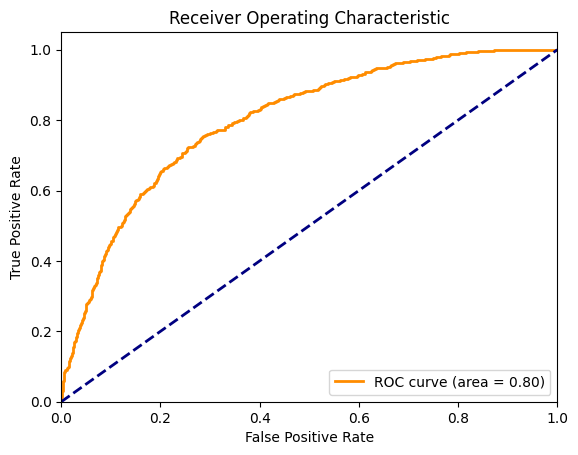

In [47]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = siamese.predict([x_test_cacd_1, x_test_cacd_2])

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_cacd, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

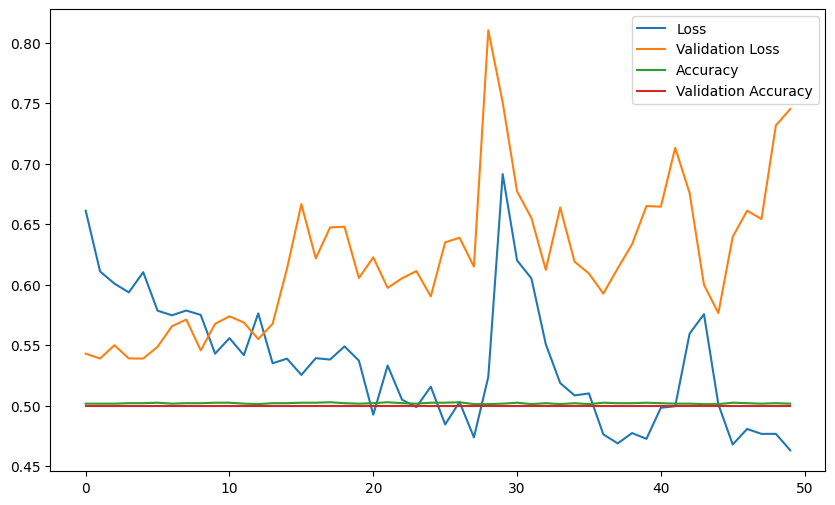

In [48]:
# Training Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["rank_1_accuracy"])
plt.plot(history.history["val_rank_1_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"]);

## 3. Model Evaluation

### 3.1. Evaluation on CACD

In [49]:
results = siamese.evaluate([x_test_cacd_1, x_test_cacd_2], y_test_cacd)
print("test loss, test acc:", results)

40/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8926 - rank_1_accuracy: 0.4950 

W0000 00:00:1712781132.287537     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8644 - rank_1_accuracy: 0.4994
test loss, test acc: [0.7997613549232483, 0.49773550033569336]


W0000 00:00:1712781132.957125     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### 3.2. Evaluation on FAGE

In [50]:
results = siamese.evaluate([x_test_fage_1, x_test_fage_2], fage_test_labels)
print("test loss, test acc:", results)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6760 - rank_1_accuracy: 0.5071
test loss, test acc: [0.5987607836723328, 0.4990079402923584]


## 4. Result Visualization

### 4.1. Visualizing CACD Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


array([[ 0.8120783 ],
       [ 0.14747162],
       [ 0.26469722],
       [ 0.35792077],
       [-0.142246  ]], dtype=float32)

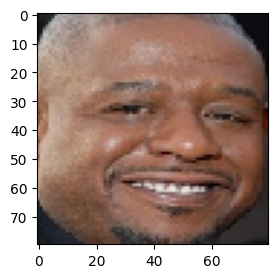

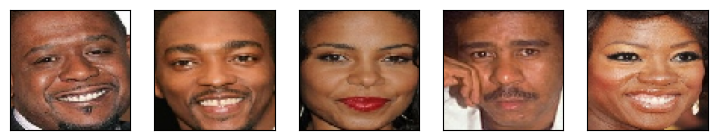

In [51]:
visualize_predictions(siamese, x_test_cacd_1, x_test_cacd_2, y_test_cacd, n=5)

### 4.2. Visualizing FAGE Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0.9803002 ],
       [0.51990247],
       [0.7289193 ],
       [0.76607597],
       [0.23123665]], dtype=float32)

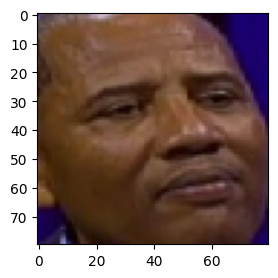

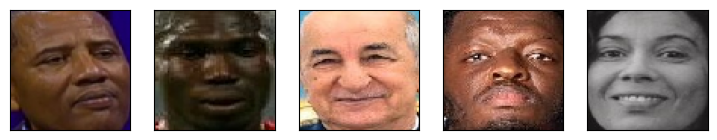

In [52]:
visualize_predictions(siamese, x_test_fage_1, x_test_fage_2, fage_test_labels, n=5)